# 人脑的外部形态

1. 即人脑看到的图像、声音、触觉 应该是人脑接受到信号后的 内部网络的再呈现! 
   - 而非直接感知外部信号的呈现! 
   - 人脑以接近beta波11赫兹进行这种呈现处理。
   - 因为某些疾病或药物导致幻想并非感知器官的病变。
   - 而某个内部信号或相关信号的激发引起网络重新出现震荡到达此前的稳定态进而呈现是构成人脑想象与联想的本质原因。
   - 因此智能模型 首先需要对输入 变换后，能够短迭代周期内几乎完全的 可以导致同样的输出。 
   - 而非目前人工智能的模型对输入进行直接处理引发分类结果。

2. 人脑是语言思考占主导地位的，而非看起来像的分类思维，人脑的结果是自以为因果的，而非统计中的期望计算。
   - 因此智能模型 需要相互交流（通过1的输出，以及语义定义与交换），
   - 可以传授（通过输出+语义可以进行处理过程的学习交换），
   - 极其怀疑（对于当前无法处理的分类可以输出+语义进行阐述） 
   - 而非目前的人工智能的孤立模型，完全通过大数据分类，强行在高维空间分割出一个分类面。

3. 知识的编码过程
    - 人的内部映射过程是反复迭代，带有预先为主的角度
    - 编码后的过程会重现后，进而再与原始重构
    - 再分解为 基础特征+变换
    - 是有预先角度 导致不同的基础特征选择，并迭代稳定

### 引入常用库

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
import input_data
import matplotlib.pyplot as plt
import os
%matplotlib inline

### 参数

In [2]:
#param

img_height = 28  
img_width = 28  
img_size = img_height * img_width

to_train = True  
to_restore = True  
output_path = "output"  

max_epoch = 50 
batch_size = 256  

### 输入数据

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### 生成器
* $x_{g}=g(z_p)$
  - $t_{1}=relu(z_p*w_1+b_1)$
  - $t_{2}=relu(t_{1}*w_2+b_2)$
  - $x_{g}=tanh(t_{2}*w_3+b_3)$

In [4]:
def build_generator(z_prior):  
    w1 = tf.Variable(tf.truncated_normal([z_size, h1_size], stddev=0.1), name="g_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h1_size]), name="g_b1", dtype=tf.float32)  
    h1 = tf.nn.relu(tf.matmul(z_prior, w1) + b1)  
    w2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=0.1), name="g_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h2_size]), name="g_b2", dtype=tf.float32)  
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)  
    w3 = tf.Variable(tf.truncated_normal([h2_size, img_size], stddev=0.1), name="g_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([img_size]), name="g_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    x_generate = tf.nn.tanh(h3)  
    g_params = [w1, b1, w2, b2, w3, b3]  
    return x_generate, g_params  

### 判别器
* $y_{d/g}=d(x_{d/g})$
  - $ x_{in}=[x_d,x_g] $
  - $ t_1= dropout(relu( x_{in}*w_1+b_1)) $
  - $ t_2= dropout(relu( t_2*w_2+b_2)) $
  - $ t_3= t_2*w_3+b_3 $
  - $ y_d = sigmoid(t_3[0:size_{batch}])$
  - $ y_g = sigmoid(t_3[size_{batch}:-1])$
  

In [5]:
def build_discriminator(x_data, x_generated, keep_prob):  
    x_in = tf.concat([x_data, x_generated], 0)  
    w1 = tf.Variable(tf.truncated_normal([img_size, h2_size], stddev=0.1), name="d_w1", dtype=tf.float32)  
    b1 = tf.Variable(tf.zeros([h2_size]), name="d_b1", dtype=tf.float32)  
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)  
    w2 = tf.Variable(tf.truncated_normal([h2_size, h1_size], stddev=0.1), name="d_w2", dtype=tf.float32)  
    b2 = tf.Variable(tf.zeros([h1_size]), name="d_b2", dtype=tf.float32)  
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)  
    w3 = tf.Variable(tf.truncated_normal([h1_size, 1], stddev=0.1), name="d_w3", dtype=tf.float32)  
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)  
    h3 = tf.matmul(h2, w3) + b3  
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))  
    y_generated = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))  
    d_params = [w1, b1, w2, b2, w3, b3]  
    return y_data, y_generated, d_params  

### 组建GAN网络
{{#}}

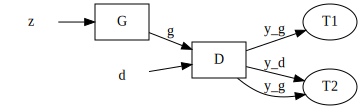

In [6]:
# Draw GAN Network flowchart
from graphviz import Digraph
from graphviz import Source
dot=Source('''
digraph {
    rankdir=LR
    D [shape=box];G [label=G shape=box]
    T1 [shape=ellipse];T2 [shape=ellipse]
    node [shape=none]
    z -> G;d -> D;G -> D [label=g];D -> T1 [label=y_g];D -> T2 [label=y_d];D -> T2 [label=y_g]
}
''');
dot

In [7]:
h1_size = 150  
h2_size = 300  
z_size = 100

x_data = tf.placeholder(tf.float32, [batch_size, img_size], name="x_data")  
z_prior = tf.placeholder(tf.float32, [batch_size, z_size], name="z_prior")  
keep_prob = tf.placeholder(tf.float32, name="keep_prob")  
global_step = tf.Variable(0, name="global_step", trainable=False)  

x_generated, g_params = build_generator(z_prior)  
y_data, y_generated, d_params = build_discriminator(x_data, x_generated, keep_prob)  

#定义优化目标函数
d_loss = - (tf.log(y_data) + tf.log(1 - y_generated))  
g_loss = - tf.log(y_generated)  

#设定优化方法
optimizer = tf.train.GradientDescentOptimizer(0.0001)  

#设定优化参数
d_trainer = optimizer.minimize(d_loss, var_list=d_params)  
g_trainer = optimizer.minimize(g_loss, var_list=g_params)  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### 结果呈现

In [8]:
import scipy.misc
def imsave(path,images):
    return scipy.misc.imsave(path, images)
def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):  
    batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5  
    img_h, img_w = batch_res.shape[1], batch_res.shape[2]  
    grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)  
    grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)  
    img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)  
    for i, res in enumerate(batch_res):  
        if i >= grid_size[0] * grid_size[1]:  
            break  
        img = (res) * 255  
        img = img.astype(np.uint8)  
        row = (i // grid_size[0]) * (img_h + grid_pad)  
        col = (i % grid_size[1]) * (img_w + grid_pad)  
        img_grid[row:row + img_h, col:col + img_w] = img  
    imsave(fname, img_grid)

### 监控(Ctrl+B)

In [9]:
#use animation do real time monitor
RT_x = np.linspace(0, 1000, 1000)
RT_y = np.zeros([2,1000],dtype='float')

In [10]:
def RT():
    import matplotlib.animation as animation
    %matplotlib notebook
    
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
    line, = ax.plot([], [], lw=2)

    def animate2(i):
        line.set_data(RT_x,RT_y[0,:])
        plt.title(''.join(['times:',str(i)]))
        return line,
    anim = animation.FuncAnimation(
        fig, animate2,  interval=500, blit=True)
    return anim
#RT()

def SS():
    fig = plt.figure()
    plt.plot(RT_y.transpose());
    plt.show();

### 训练GAN

In [11]:
def train():  
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)  
    init = tf.global_variables_initializer()  
    saver = tf.train.Saver()  
    sess = tf.Session()  
    sess.run(init)  
    
    if to_restore:  
        chkpt_fname = tf.train.latest_checkpoint(output_path)
        print(chkpt_fname)
        saver.restore(sess, chkpt_fname)  
    else:  
        if os.path.exists(output_path):  
            shutil.rmtree(output_path)  
        os.mkdir(output_path)

    for i in range(sess.run(global_step), max_epoch):  
        for j in range(60000 / batch_size):  
            x_value, _ = mnist.train.next_batch(batch_size)  
            x_value = 2 * x_value.astype(np.float32) - 1  
            z_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)  
            _,d_l=sess.run([d_trainer,d_loss],  
                     feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)})  
            #if j % 1 == 0:  
            _,g_l=sess.run([g_trainer,g_loss], 
                         feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)}) 
        #print np.mean(g_l)
        RT_y[0,i]=np.mean(d_l);
        RT_y[1,i]=np.mean(g_l);
        if(i%10==0) :
                print "epoch:%s, d_loss:%f,g_loss:%f" % (i, np.mean(d_l),np.mean(g_l))  
        if (i%50==0):
            z_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)  
            x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val})  
            show_result(x_gen_val, os.path.join(output_path, "sample%s.jpg" % i))  
            sess.run(tf.assign(global_step, i + 1))  
            saver.save(sess, os.path.join(output_path, "model"), global_step=global_step)  

In [ ]:
h1_size = 150  
h2_size = 300  
z_size = 100
import shutil
max_epoch = 1000
train();

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
output/model-1
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from output/model-1
epoch:0, d_loss:0.964235,g_loss:0.878101


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


epoch:10, d_loss:0.988676,g_loss:1.455994
epoch:20, d_loss:0.835507,g_loss:1.502312
epoch:30, d_loss:0.776289,g_loss:1.629739
epoch:40, d_loss:0.896620,g_loss:1.449046
epoch:50, d_loss:0.785238,g_loss:1.553027
epoch:60, d_loss:0.870231,g_loss:1.494320
epoch:70, d_loss:0.942693,g_loss:1.466509
epoch:80, d_loss:0.957283,g_loss:1.518434
epoch:90, d_loss:0.831290,g_loss:1.561775
epoch:100, d_loss:0.988125,g_loss:1.525333
epoch:110, d_loss:0.946911,g_loss:1.469787


In [ ]:
SS()

### 新构建模型
* 眼脑特征
  1. 30s以上看一个物品，突然闭眼后可以看到反色图像
  1. 长期看一个物品，可以看到物品不存在
  1. 点状图像呈现区间的暗点
  1. 药物作用或血糖作用，看到的物品变形或噪声
  1. 看到静态图像产生动态效果（视觉错觉）
  1. 某些人的大脑可以对图像进行全部记忆，而非反色像
  1. 做梦也不是反色像
  1. 类似于牛鞭效应（Src平衡Dst，Src的剧烈变化牵动Dst到极反向）
  1. 可以进行视觉方式欺骗图像构成动画！用于研究
* 智能模式
  1. 产生‘1’的大体印象
  1. 进行新的‘1’的变换的学习，学习变换方式与运用变换的方式

<img src="EyeBrainImg/27a.gif",width=200,height=200>
<img src="EyeBrainImg/10.jpg",width=200,height=200>

* 阶段进展
  1. 人眼响应5s左右，消逝瞬间产生3s左右反色响应
  1. 先由原色->目标色，突破目标色 产生‘等距离’偏移到达虚反色
  1. 虚反色逐步与目标色过度3s左右，形成最终目标色
  1. 虚反色与当前色有叠加效应，当前色时间过短不足以产生消逝虚反色
  1. 人眼响应RGB或是YUV未进行实验,倾向于YUV实验结果
  1. 形式上为跟随器的效果，5s学习，3s回忆
  1. 跟随的效果是输入产生的，还是特征反卷积形成的呢???
  1. 完全由想象产生的虚像是否可以与实际图像产生叠加，如果想象产生的虚像等效与虚反色像则虚反色像不是输入诱导的
  1. 人眼中心没有虚反色，边缘容易产生虚反色图像

#### 新设计网络结构

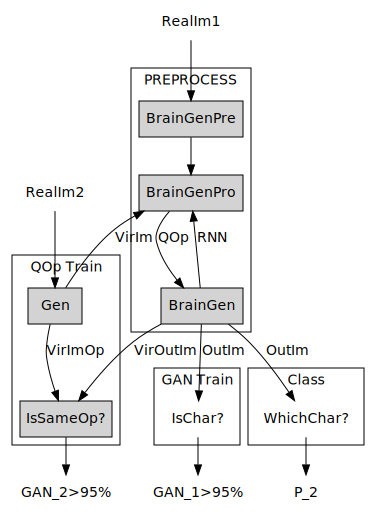

In [46]:
#
from graphviz import Source
dot = Source('''

digraph G{
    rankdir=TB;compound=true;node [shape=none];
    
    //QOperation [shape=ellipse,style=filled];
    
    subgraph cluster0 {
        label ="PREPROCESS"
        node [shape=box,style=filled];
        BrainGenPre;BrainGenPro;BrainGen;
    }
   
    subgraph cluster1 {
        label ="GAN Train"
        "IsChar?";
    }
    
    subgraph cluster2 {
        label ="Class"
        "WhichChar?"
    }
    
    subgraph cluster3 {
        label ="QOp Train"
        node [shape=box,style=filled];
        "Gen";"IsSameOp?"
    }
    
    RealIm1 -> BrainGenPre
    BrainGenPre -> BrainGenPro
    //QOperation -> BrainGenPro
    //QOperation -> Gen
    BrainGenPro -> BrainGen [label="QOp"]
    BrainGen -> "IsChar?" [label="OutIm"]
    
    BrainGen-> BrainGenPro [label="RNN"]
    
    "IsChar?" -> "GAN_1>95%"
    
    BrainGen -> "WhichChar?" [label="OutIm"]
    "WhichChar?" -> "P_2"
    
    "Gen" -> BrainGenPro [label="VirIm"]
    "Gen" -> "IsSameOp?" [label="VirImOp"]
    
    
    "IsSameOp?" -> "GAN_2>95%"
    
    RealIm2 -> Gen
    BrainGen -> "IsSameOp?" [label="VirOutIm"]
    
}''');
dot

#### 原始GAN网络结构

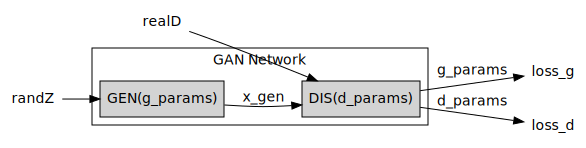

In [47]:
#原始的GAN网络，训练的参数独立，目标独立形成对抗关系

from graphviz import Source
dot = Source('''
digraph G{
    rankdir=LR;compound=true;node [shape=none];
    //QOperation [shape=ellipse,style=filled];
    subgraph cluster0 {
        label ="GAN Network"
        node [shape=box,style=filled];
        GEN [shape=box,label="GEN(g_params)"]
        DIS [shape=box,label="DIS(d_params)"]
        GEN -> DIS [label="x_gen"]
    }
    randZ -> GEN
    realD -> DIS
    DIS -> "loss_g" [label=g_params]
    DIS -> "loss_d" [label=d_params]
}''');
dot

#### 改进的GAN网络结构1
- g_params重复更新存在矛盾
- 神经网络为集合方式的大数据形式进行矩阵求解，因此无法单案例进行优化
- 将GEN划分为2个参数集，g_par2实现GEN，g_par1实现特征提取
  - 希望x_gen=原始字符的变形、fea成为原始字符的形状特征、并有效的进行字符识别
  - 缺点为CharClass可以收敛，但x_gen的鉴别能力不强
  - fea并不能夹逼为 图像的特征内容
  - 因为参数具有依赖性，并不是其他参数固定的情况下，当前参数具备最优解并且可以独立迭代，而是全局最优才是最优！！！

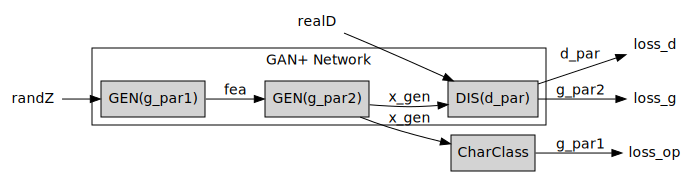

In [104]:
#新的GAN网络

import sys;sys.setdefaultencoding('utf8') #中文支持

from graphviz import Source
dot = Source('''

digraph G{
    rankdir=LR;compound=true;node [shape=none];
    subgraph cluster0 {
        label ="GAN+ Network"
        node [shape=box,style=filled];
        GEN1 [shape=box,label="GEN(g_par1)"]
        GEN2 [shape=box,label="GEN(g_par2)"]
        DIS [shape=box,label="DIS(d_par)"]
        GEN1 -> GEN2 [label="fea"]
        GEN2 -> DIS [label="x_gen"]
    }
    randZ -> GEN1
    realD -> DIS
    
    DIS -> "loss_d" [label=d_par]
    DIS -> "loss_g" [label=g_par2]
    
    CharClass [shape=box,style=filled];
    GEN2 -> CharClass [label=x_gen]
    CharClass -> "loss_op" [label="g_par1"]

}''')
dot

#### 改进的GAN网络结构2
- 训练强化fea,并且势必加强fea成为字符表达的充分条件
- 通过fea进行数据生成
- 目的为加强x_gen的生成变化，将GEN2形成特征变换??? -> 是否是人字符识别的原理

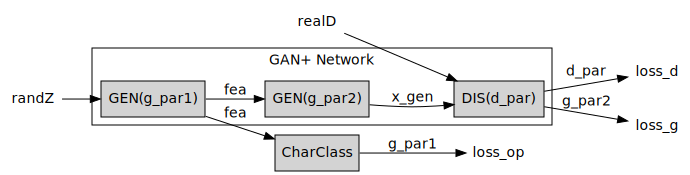

In [114]:
#新的GAN网络

import sys;sys.setdefaultencoding('utf8') #中文支持

from graphviz import Source
dot = Source('''

digraph G{
    rankdir=LR;compound=true;node [shape=none];
    subgraph cluster0 {
        label ="GAN+ Network"
        node [shape=box,style=filled];
        GEN1 [shape=box,label="GEN(g_par1)"]
        GEN2 [shape=box,label="GEN(g_par2)"]
        DIS [shape=box,label="DIS(d_par)"]
        GEN1 -> GEN2 [label="fea"]
        GEN2 -> DIS [label="x_gen"]
    }
    randZ -> GEN1
    realD -> DIS
    
    DIS -> "loss_d" [label=d_par]
    DIS -> "loss_g" [label=g_par2]
    
    CharClass [shape=box,style=filled];
    GEN1 -> CharClass [label=fea]
    CharClass -> "loss_op" [label="g_par1"]

}''')
dot